In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import catalogs_to_csv as cat
#cat.get_catalogs()
mpl.rcParams['font.size'] = 20
import frb_catalog_plots as plot

Loading all FRBs from catalogs


TypeError: object of type 'numpy.bool_' has no len()

In [2]:
frbs=cat.load_frbs()

Loading all FRBs from catalogs


Loading all FRBs from catalogs


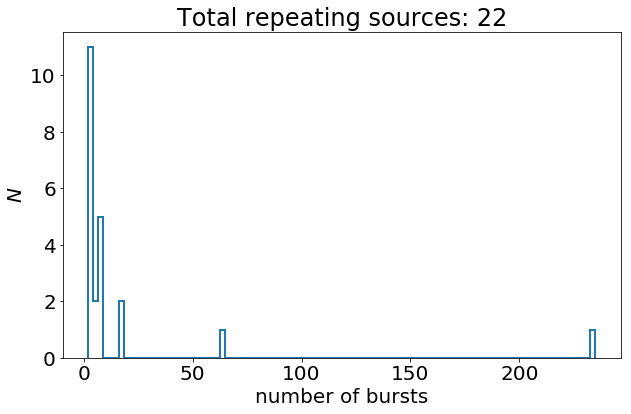

In [16]:
plot.repeater_bursts()

In [ ]:
year_bins = [Time(f'20{year:02d}-01-01 00:00:00', format='iso').mjd for year in range(8, 22)]
fig, ax = plt.subplots(figsize=(10,6))
plt.hist([frbs['mjd'][i] for i in non_rep], bins=year_bins, histtype='step', lw=2., label='non-repeaters')
plt.hist([frbs['mjd'][i] for i in rep], bins=year_bins, histtype='step', lw=2., label='repeaters')

plt.legend(loc=2)
plt.xlabel('MJD')
plt.ylabel(r'$N$')
ax.set_title(r'Distribution of FRBs by Date', fontsize=20)